### 3.7. Weight Decay

http://preview.d2l.ai/d2l-en/master/chapter_linear-regression/weight-decay.html
Now that we have characterized the problem of overfitting, we can introduce our first regularization technique. Recall that we can always mitigate overfitting by collecting more training data. However, that can be costly, time consuming, or entirely out of our control, making it impossible in the short run. For now, we can assume that we already have as much high-quality data as our resources permit and focus the tools at our disposal when the dataset is taken as a given.

Recall that in our polynomial regression example (Section 3.6.2.1) we could limit our model’s capacity by tweaking the degree of the fitted polynomial. Indeed, limiting the number of features is a popular technique for mitigating overfitting. However, simply tossing aside features can be too blunt an instrument. Sticking with the polynomial regression example, consider what might happen with high-dimensional input. The natural extensions of polynomials to multivariate data are called monomials, which are simply products of powers of variables. The degree of a monomial is the sum of the powers. For example, 
, and are both monomials of degree 3.

Note that the number of terms with degree $d$ blows up rapidly as 
 grows larger. Given $k$ variables, the number of monomials of  $d$ is $C(k-1+d,k-1)$. Even small changes in degree, say from 2 to 3, dramatically increase the complexity of our model. Thus we often need a more fine-grained tool for adjusting function complexity.

In [2]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

2024-02-12 19:49:08.401971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 19:49:08.402000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 19:49:08.402843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 19:49:08.408208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 19:49:09.222370: W tensorflow/compiler/tf2

3.7.1. Norms and Weight Decay
Rather than directly manipulating the number of parameters, weight decay, operates by restricting the values that the parameters can take. More commonly called 
 regularization outside of deep learning circles when optimized by minibatch stochastic gradient descent, weight decay might be the most widely used technique for regularizing parametric machine learning models. The technique is motivated by the basic intuition that among all functions 
, the function 
 (assigning the value 
 to all inputs) is in some sense the simplest, and that we can measure the complexity of a function by the distance of its parameters from zero. But how precisely should we measure the distance between a function and zero? There is no single right answer. In fact, entire branches of mathematics, including parts of functional analysis and the theory of Banach spaces, are devoted to addressing such issues.

One simple interpretation might be to measure the complexity of a linear function 
 by some norm of its weight vector, e.g., 
. Recall that we introduced the 
 norm and 
 norm, which are special cases of the more general 
 norm, in Section 2.3.11. The most common method for ensuring a small weight vector is to add its norm as a penalty term to the problem of minimizing the loss. Thus we replace our original objective, minimizing the prediction loss on the training labels, with new objective, minimizing the sum of the prediction loss and the penalty term. Now, if our weight vector grows too large, our learning algorithm might focus on minimizing the weight norm 
 rather than minimizing the training error. That is exactly what we want. To illustrate things in code, we revive our previous example from Section 3.1 for linear regression. There, our loss was given by

(3.7.1)
Recall that 
 are the features, 
 is the label for any data example 
, and 
 are the weight and bias parameters, respectively. To penalize the size of the weight vector, we must somehow add 
 to the loss function, but how should the model trade off the standard loss for this new additive penalty? In practice, we characterize this trade-off via the regularization constant 
, a nonnegative hyperparameter that we fit using validation data:

(3.7.2)
For 
, we recover our original loss function. For 
, we restrict the size of 
. We divide by 
 by convention: when we take the derivative of a quadratic function, the 
 and 
 cancel out, ensuring that the expression for the update looks nice and simple. The astute reader might wonder why we work with the squared norm and not the standard norm (i.e., the Euclidean distance). We do this for computational convenience. By squaring the 
 norm, we remove the square root, leaving the sum of squares of each component of the weight vector. This makes the derivative of the penalty easy to compute: the sum of derivatives equals the derivative of the sum.

Moreover, you might ask why we work with the 
 norm in the first place and not, say, the 
 norm. In fact, other choices are valid and popular throughout statistics. While 
-regularized linear models constitute the classic ridge regression algorithm, 
-regularized linear regression is a similarly fundamental method in statistics, popularly known as lasso regression. One reason to work with the 
 norm is that it places an outsize penalty on large components of the weight vector. This biases our learning algorithm towards models that distribute weight evenly across a larger number of features. In practice, this might make them more robust to measurement error in a single variable. By contrast, 
 penalties lead to models that concentrate weights on a small set of features by clearing the other weights to zero. This gives us an effective method for feature selection, which may be desirable for other reasons. For example, if our model only relies on a few features, then we may not need to collect, store, or transmit data for the other (dropped) features.

Using the same notation in (3.1.11), minibatch stochastic gradient descent updates for 
-regularized regression as follows:

(3.7.3)
As before, we update 
 based on the amount by which our estimate differs from the observation. However, we also shrink the size of 
 towards zero. That is why the method is sometimes called “weight decay”: given the penalty term alone, our optimization algorithm decays the weight at each step of training. In contrast to feature selection, weight decay offers us a mechanism for continuously adjusting the complexity of a function. Smaller values of 
 correspond to less constrained 
, whereas larger values of 
 constrain 
 more considerably. Whether we include a corresponding bias penalty 
 can vary across implementations, and may vary across layers of a neural network. Often, we do not regularize the bias term. Besides, although 
 regularization may not be equivalent to weight decay for other optimization algorithms, the idea of regularization through shrinking the size of weights still holds true.

#### 3.7.2. High-Dimensional Linear Regression¶

In [3]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tf.random.normal((n, num_inputs))
        noise = tf.random.normal((n, 1)) * 0.01
        w, b = tf.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = tf.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

#### 3.7.3.1. Defining 
 Norm Penalty
Perhaps the most convenient way of implementing this penalty is to square all terms in place and sum them.

#### 3.7.3.2. Defining the Model¶
In the final model, the linear regression and the squared loss have not changed since Section 3.4, so we will just define a subclass of d2l.LinearRegressionScratch. The only change here is that our loss now includes the penalty term.

In [5]:
def l2_penalty(w):
    return tf.reduce_sum(w**2) / 2

In [6]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [7]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.00021705447579734027


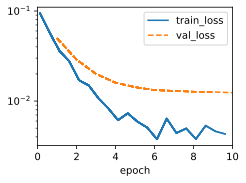

In [20]:
train_scratch(10)

#### 3.7.4. Concise Implementation
Because weight decay is ubiquitous in neural network optimization, the deep learning framework makes it especially convenient, integrating weight decay into the optimization algorithm itself for easy use in combination with any loss function. Moreover, this integration serves a computational benefit, allowing implementation tricks to add weight decay to the algorithm, without any additional computational overhead. Since the weight decay portion of the update depends only on the current value of each parameter, the optimizer must touch each parameter once anyway.

In [16]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.net = tf.keras.layers.Dense(
            1, kernel_regularizer=tf.keras.regularizers.l2(wd),
            kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.01)
        )

    def loss(self, y_hat, y):
        return super().loss(y_hat, y) + self.net.losses

L2 norm of w: 0.0002710622502490878


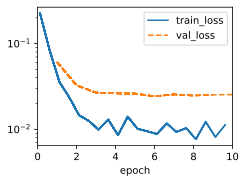

In [21]:
model = WeightDecay(wd=10, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))